<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/PyTorch_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

In [ ]:
# We will get mask-rcnn model for this video
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [ ]:
model = model.cuda() # I forgot to change to GPU, coment this line if no GPU

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# I will link the notebook in the description
# You can copy the class names from the description
# or the notebook
len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

91

In [ ]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO
# the io and requests libraries are just for loading images from URLS

In [ ]:
def get_prediction(img_path, threshold=0.5, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [ ]:
import cv2 # opencv

In [ ]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
  resp = urlopen(url) # We want to convert URL to cv2 image here, so we can draw the mask and bounding boxes
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, readFlag)
  return image

In [ ]:
import random

In [ ]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [ ]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [ ]:
img, pred_classes, masks = instance_segmentation('44.jpg', rect_th=5, text_th=4)

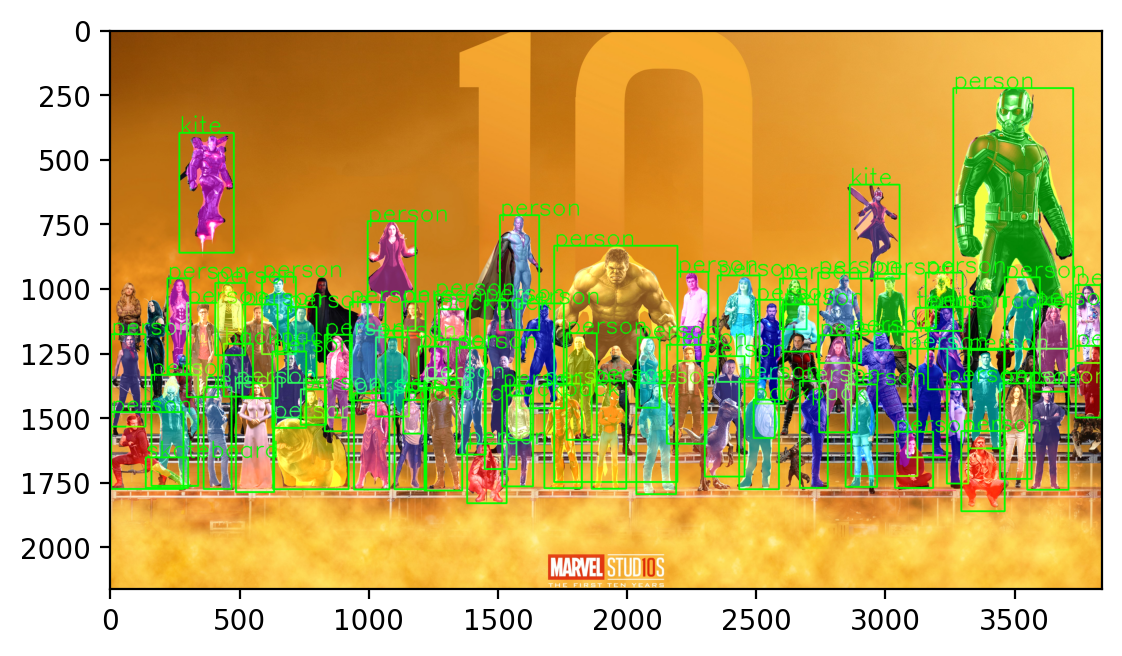

In [ ]:
plt.imshow(img)

In [ ]:
pred_classes